# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

# Project Plan


This project is divided into 8 parts, and they are following the CRISP-DM model. It includes data preparation, analysis generation, feature creation, Machine Learning modeling and model evaluation. The ultimate goal is to create a model capable of predicting whether a customer has **consciously** completed an offer. This detail is important, as this project took into account conversions in which customers used the available offer after seeing the offer.  

To make this possible with the available data set, the data were treated so that each line is an offer received with the other information, including whether the offer was seen and completed. This transformation will be done through a pivot table of transaction data, made with functions created in the project.   

The final model must be compared to a specific baseline. The baseline that will be used in this project: All customers convert. That is, send coupon to all customers.   

For the choice of model, I will list some famous classification models and determine the one that best performs in the dataset as the final model. Also, the Hyperparameter Fine Tuning will be done to try to further improve the performance of the model.  

To evaluate the model, several metrics will be used. Among them: Accuracy, Precision, Recall, F1, ROC-AUC. However, the main metric for this model will be **Precision**, because for this project the focus is to improve the model's accuracy in relation to positive cases.   

Every model will be developed in a way that does not allow data leakage. Furthermore, cross-validation will be applied so that the results are more accurate.

In addition to all the predictive modeling, an entire data analysis will be done. From a descriptive/statistical analysis of the variables, to the generation of insights during the EDA process.   

The ultimate goal is to come up with a model that predicts with more than 70% accuracy those customers who knowingly converted to test data.

# Indice
### 1.0. Imports
### 2.0. Data Prepare
### 3.0. Feature Engineering
### 4.0. Exploratory Data Analysis
### 5.0. Data Pre-Processing
### 6.0. Model
### 7.0. Hyperparameter Fine Tuning
### 8.0. Evaluating

# 1.0. Imports

In [83]:
import pandas as pd
import numpy as np
import math
import json
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import statistics

from sklearn import model_selection as ms
from sklearn import feature_selection as fs
from sklearn import linear_model as lm
from sklearn import metrics as me
from sklearn.impute import SimpleImputer
import catboost                                       as cb
from lightgbm import LGBMClassifier
import xgboost
from sklearn.pipeline import Pipeline
from sklearn import metrics
import sklearn.ensemble as en

%matplotlib inline
plt.rcParams['figure.figsize'] = [25, 12]
plt.rcParams['font.size'] = 24
sns.set()

## 1.1. Data

In [2]:
# read in the json files\
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# 2.0. Data Prepare

## 2.1. Portfolio

In [3]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [4]:
print(f'Number of rows: {portfolio.shape[0]}')
print(f'Number of columns: {portfolio.shape[1]}')

Number of rows: 10
Number of columns: 6


### 2.1.1. Transform Columns
In this transformation, the data from the channels column will be exploded and transformed into columns
where 1 means presence and 0 absence.

In [75]:
def clean_channels(list_channels, portfolio=portfolio):
    """
    Function to transform list channels in new columns 
    with each channel in a different column.
    """
    df = portfolio
    
    for channel in list_channels:
        channel_name = f'c_{channel}'
        df[channel_name] = [1 if channel in row['channels'] else 0 for index, row in df.iterrows()]
    df = df.drop('channels', axis=1)
    
    return df

In [6]:
# Listing available channels
list_channels = ['web', 'email', 'mobile', 'social']

df_portfolio = clean_channels(list_channels)

### 2.1.2. Na Values
No missing values in this table.

In [7]:
df_portfolio.isnull().sum()

reward        0
difficulty    0
duration      0
offer_type    0
id            0
c_web         0
c_email       0
c_mobile      0
c_social      0
dtype: int64

### 2.1.3. Dtypes
All dtypes correct.

In [8]:
df_portfolio.dtypes

reward         int64
difficulty     int64
duration       int64
offer_type    object
id            object
c_web          int64
c_email        int64
c_mobile       int64
c_social       int64
dtype: object

## 2.2. Profile

In [9]:
df_profile = profile.copy()
df_profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [10]:
print(f'Number of rows: {df_profile.shape[0]}')
print(f'Number of columns: {df_profile.shape[1]}')

Number of rows: 17000
Number of columns: 5


### 2.2.1. Transform Columns
The only necessary transformation in this column is to change the type of the date column.

In [11]:
# Transform date column
df_profile['became_member_on'] = pd.to_datetime(df_profile['became_member_on'], format='%Y%m%d')

### 2.2.2. Na Values
Here it is possible to find null values in gender and income. By pattern analysis, the null values are all from the same users.   
This behavior will be investigated and during modeling these values will be substituted.

In [12]:
round((df_profile.isnull().sum() / df_profile.shape[0]) * 100, 2)

gender              12.79
age                  0.00
id                   0.00
became_member_on     0.00
income              12.79
dtype: float64

<AxesSubplot:>

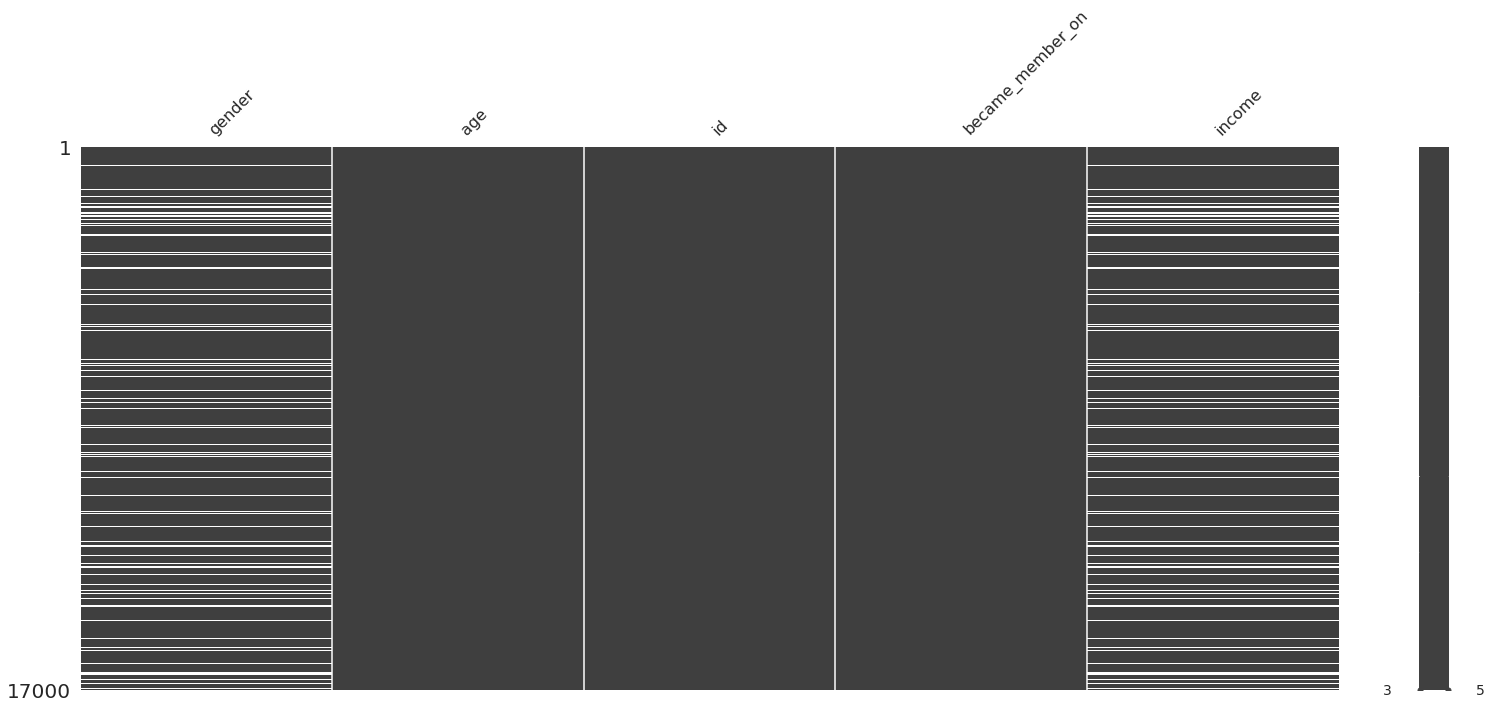

In [13]:
msno.matrix(df_profile)

#### Age 
All age values = 118 are from null profile values.    
These null values are shared with the same null lines in gender and income.   
I will substitute the values from 118 to nan so that they can be properly handled.

<AxesSubplot:>

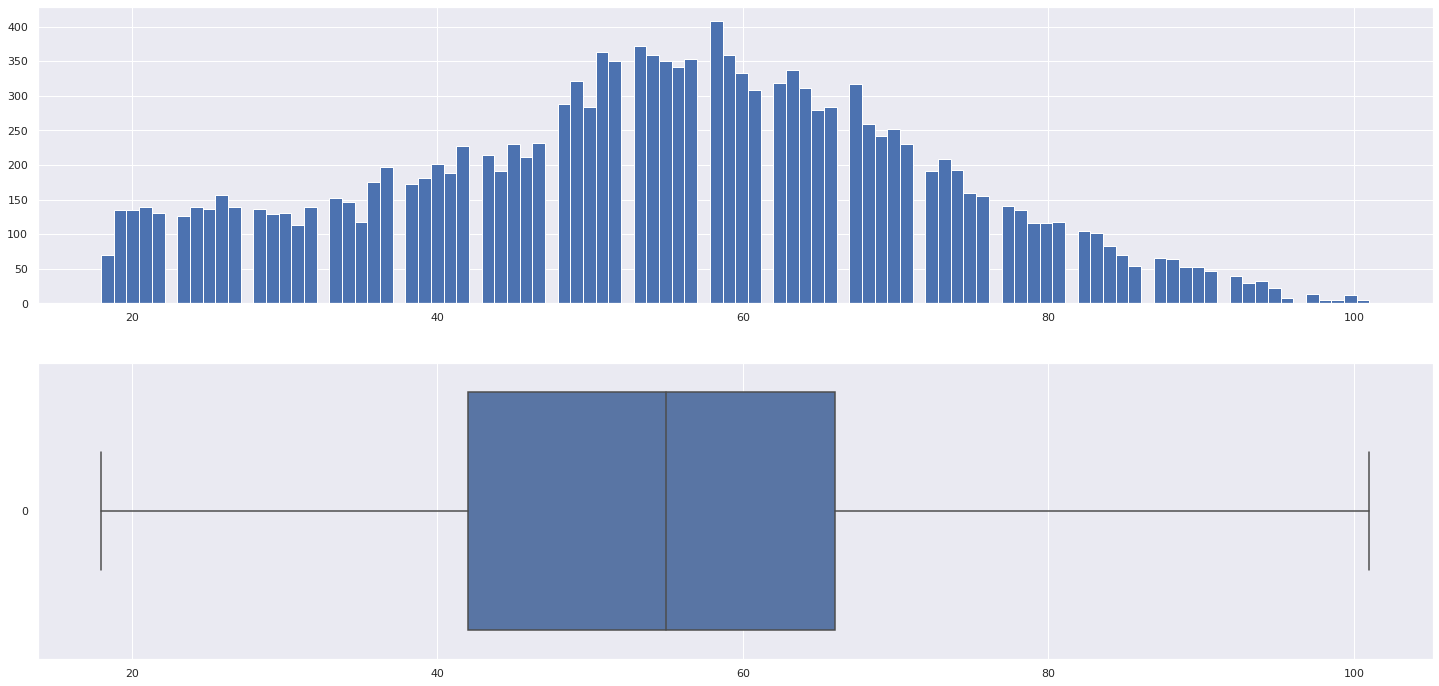

In [76]:
grid = plt.GridSpec(2, 1)

plt.subplot(grid[0, 0])
df_profile['age'].hist(bins=100)

plt.subplot(grid[1, 0])
sns.boxplot(data=df_profile['age'], orient='h')

In [15]:
df_profile.loc[df_profile['age'] == 118, 'age'] = np.nan

#### Gender
Only categorical data will be treated at that time. Continuous data will be handled during the model to avoid data leakage.
Missing data will be replaced by **unknown**.

In [16]:
df_profile['gender'] = df_profile['gender'].fillna('unknown')

### 2.2.3. dtypes
All dtypes correct.

In [17]:
df_profile.dtypes

gender                      object
age                        float64
id                          object
became_member_on    datetime64[ns]
income                     float64
dtype: object

## 2.3. Transcript

In [18]:
df_transcript = transcript.copy()
df_transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [19]:
print(f'Number of rows: {df_transcript.shape[0]}')
print(f'Number of columns: {df_transcript.shape[1]}')

Number of rows: 306534
Number of columns: 4


### 2.3.1. Transform Columns 
To do this transformation, I will take the values ​​that are inserted into the dictionaries in the value column.   
This column will be divided into **value** with the monetary value for entries with transactions and **code** for entries with status of orders.   
I will also merge it with the portfolio table to make it easier during feature engineering. From this table, **duration** and **offer_type** will be used. **duration** will be multiplied by 24 to extract the duration in hours.

In [20]:
# Transforming value columns
clean_value = (
    lambda x: str(x.values())
    .split('[')[1] #split per "[" and get second value
    .split(']')[0] #split per "]" and get first value
    .split(',')[0] #split per "," and get first value
    .strip("'") #taking "'" from values
) 

aux = df_transcript['value'].apply(clean_value)

df_transcript = transcript.assign(value=aux)

df_transcript = df_transcript.assign(code=df_transcript['value']).reset_index(drop=True)

df_transcript['value'] = df_transcript['value'].apply(lambda x: None if '.' not in x else x).astype('float')

In [21]:
join_portfolio = df_portfolio.loc[:, ['id', 'offer_type', 'duration']]

In [22]:
df_transcript = pd.merge(df_transcript, join_portfolio, left_on='code', right_on='id', how='outer').drop('id', axis=1)

# Ordering by person and time
df_transcript = df_transcript.sort_values(['person', 'time'])

# clean code
df_transcript['code'] = df_transcript['code'].apply(lambda x: None if '.' in x else x)

In [23]:
df_transcript['duration'] = df_transcript.loc[df_transcript['event'] == 'offer received', 'duration'] * 24

In [24]:
df_transcript.head()

,person,event,value,time,code,offer_type,duration
155971,0009655768c64bdeb2e877511632db8f,offer received,NaN,168,5a8bc65990b245e5a138643cd4eb9837,informational,72.0
157631,0009655768c64bdeb2e877511632db8f,offer viewed,NaN,192,5a8bc65990b245e5a138643cd4eb9837,informational,NaN
269631,0009655768c64bdeb2e877511632db8f,transaction,22.16,228,None,NaN,NaN
127775,0009655768c64bdeb2e877511632db8f,offer received,NaN,336,3f207df678b143eea3cee63160fa8bed,informational,96.0
129199,0009655768c64bdeb2e877511632db8f,offer viewed,NaN,372,3f207df678b143eea3cee63160fa8bed,informational,NaN


### 2.3.2. Na Values
These Na values are normal.

In [25]:
df_transcript.isnull().sum() / len(df_transcript)

person        0.000000
event         0.000000
value         0.546696
time          0.000000
code          0.453304
offer_type    0.453304
duration      0.751163
dtype: float64

### 2.3.3. dtypes
All dtypes correct.

In [26]:
df_transcript.dtypes

person         object
event          object
value         float64
time            int64
code           object
offer_type     object
duration      float64
dtype: object

# 3.0. Feature Engineering

In [27]:
aux_transcript = df_transcript.loc[df_transcript['offer_type'] != 'informational']

In [230]:
def pivot_transactions(df):
    """
    Function that transforms a dataframe into a pivot table with 5 columns:
        - person: person code
        - code: offer code
        - offer_completed: 1 - complete 0 - not complete
        - offer_received: 1 - received
        - offer_viewed: 1 - viewed 0 - not viewed
    """
    # Exclude transactions
    df = df.loc[
        (df['event'] == 'offer received')
        | (df['event'] == 'offer completed')
        | (df['event'] == 'offer viewed')
        , ['person', 'code', 'event']
    ]
    # Columns to count
    df['counter'] = 1
    # Pivot table
    aux = df.pivot_table(values='counter', index=['person', 'code'], 
                         columns='event', aggfunc=sum).reset_index()
    aux.columns = ['person', 'code', 'offer_completed', 
                   'offer_received', 'offer_viewed']
    # Replace Na
    aux.fillna(0, inplace=True)
    # Change dtypes
    aux['offer_completed'] = aux['offer_completed'].astype(int)
    aux['offer_received'] = aux['offer_received'].astype(int)
    aux['offer_viewed'] = aux['offer_viewed'].astype(int)
    
    # The pivot table counts the number of cases. Here these 
    # case numbers will be exploded into lines
    c = 0
    aux_2 = aux.loc[aux['offer_received'] > 1]

    dict_rows = {}
    for index, row in aux_2.iterrows():
        num_rec = row['offer_received']
        for count in range(1, num_rec):
            c += 1
            dict_rows[c] = [row['person'], row['code'], 
                            row['offer_completed'] - count,
                            row['offer_received'],
                            row['offer_viewed'] - count]
            
    append_rows = pd.DataFrame(dict_rows).T
    append_rows.columns = ['person', 'code', 'offer_completed', 'offer_received', 'offer_viewed']
    # concat
    aux = pd.concat([aux, append_rows])
    
    list_columns = ['offer_completed', 'offer_received', 'offer_viewed']
    for column in list_columns:
        aux[column] = aux[column].apply(lambda x: 0 if x <= 0 else 1)
        
    return aux.sort_values(by=['person', 'code'])

## 3.1. Join
Joining all tables and selecting only the columns of interest.

In [231]:
# Declaring the pivot table
df = pivot_transactions(aux_transcript)

In [232]:
# Merges
df = pd.merge(df, df_profile, left_on='person', right_on='id')
df = pd.merge(df, df_portfolio, left_on='code', right_on='id')

In [233]:
# Selecting columns
df = df[['person', 'age', 'gender', 'income', 'became_member_on',
         'code', 'offer_type', 'reward', 'duration', 'difficulty', 
         'c_web', 'c_email', 'c_mobile', 'c_social', 'offer_received', 
         'offer_viewed', 'offer_completed']]

## 3.2. Missing Data
Null values are the result of entries without information in the profile. I will create a new column that determines if the value is null or not

In [32]:
df['missing_profile'] = df['income'].apply(lambda x: 1 if pd.isnull(x) else 0)

## 3.3. Response Variable - Completed offer consciously
Not all completed offers are made knowingly. Completed unseen offers should not be considered a success.

In [33]:
df['consciously_complete'] = [1 if (row['offer_viewed'] == 1 & row['offer_completed'] == 1) else 0
                             for index, row in df.iterrows()]

## 3.4. Days Member
Turning the date column into how many days the person is a member. For this, the value of the day is being subtracted from the maximum value of the dataset.

In [234]:
delta_days = [(df['became_member_on'].max().date() - row['became_member_on'].date()).days for index, row in df.iterrows()]

In [235]:
df['delta_days'] = delta_days

# 4.0. Exploratory Data Analysis

In [37]:
df4 = df.copy()

## 4.1. Univariate Analysis

### 4.1.1. Numerical Variables

#### Profile

In [39]:
df_profile.describe()

,age,income
count,14825.000000,14825.000000
mean,54.393524,65404.991568
std,17.383705,21598.299410
min,18.000000,30000.000000
25%,42.000000,49000.000000
50%,55.000000,64000.000000
75%,66.000000,80000.000000
max,101.000000,120000.000000


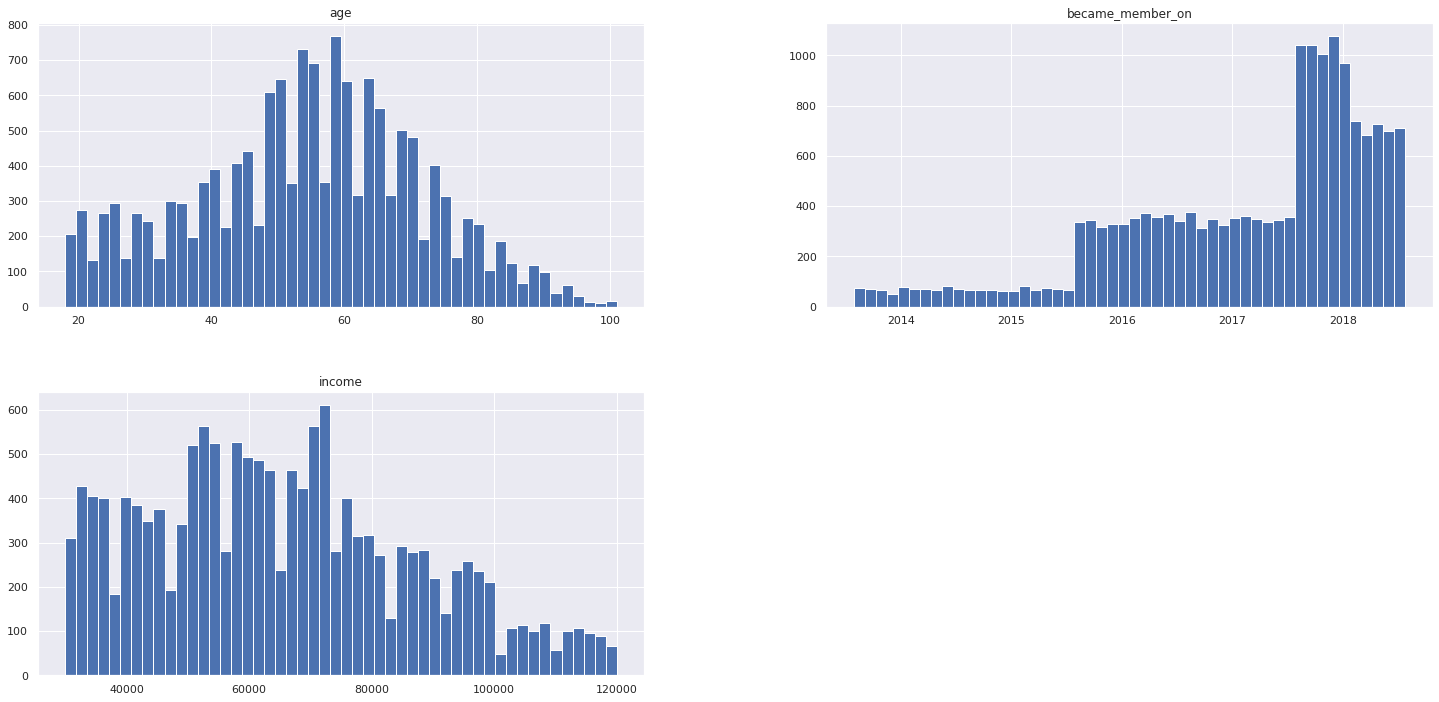

In [38]:
df_profile.hist(bins=50);

#### Transaction

In [41]:
df4.drop(['age', 'income', 'became_member_on'], axis=1).describe()

,reward,duration,difficulty,c_web,c_email,c_mobile,c_social,offer_received,offer_viewed,offer_completed,missing_profile,consciously_complete,delta_days
count,61042.000000,61042.000000,61042.000000,61042.000000,61042.0,61042.000000,61042.000000,61042.0,61042.000000,61042.000000,61042.000000,61042.000000,61042.000000
mean,5.250254,7.253383,9.631434,0.874545,1.0,0.874382,0.623587,1.0,0.768225,0.550097,0.128453,0.457881,516.575636
std,2.988313,1.783308,4.449554,0.331236,0.0,0.331422,0.484490,0.0,0.421969,0.497488,0.334596,0.498227,411.422946
min,2.000000,5.000000,5.000000,0.000000,1.0,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,7.000000,7.000000,1.000000,1.0,1.000000,0.000000,1.0,1.000000,0.000000,0.000000,0.000000,207.000000
50%,5.000000,7.000000,10.000000,1.000000,1.0,1.000000,1.000000,1.0,1.000000,1.000000,0.000000,0.000000,357.000000
75%,5.000000,10.000000,10.000000,1.000000,1.0,1.000000,1.000000,1.0,1.000000,1.000000,0.000000,1.000000,792.000000
max,10.000000,10.000000,20.000000,1.000000,1.0,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1823.000000


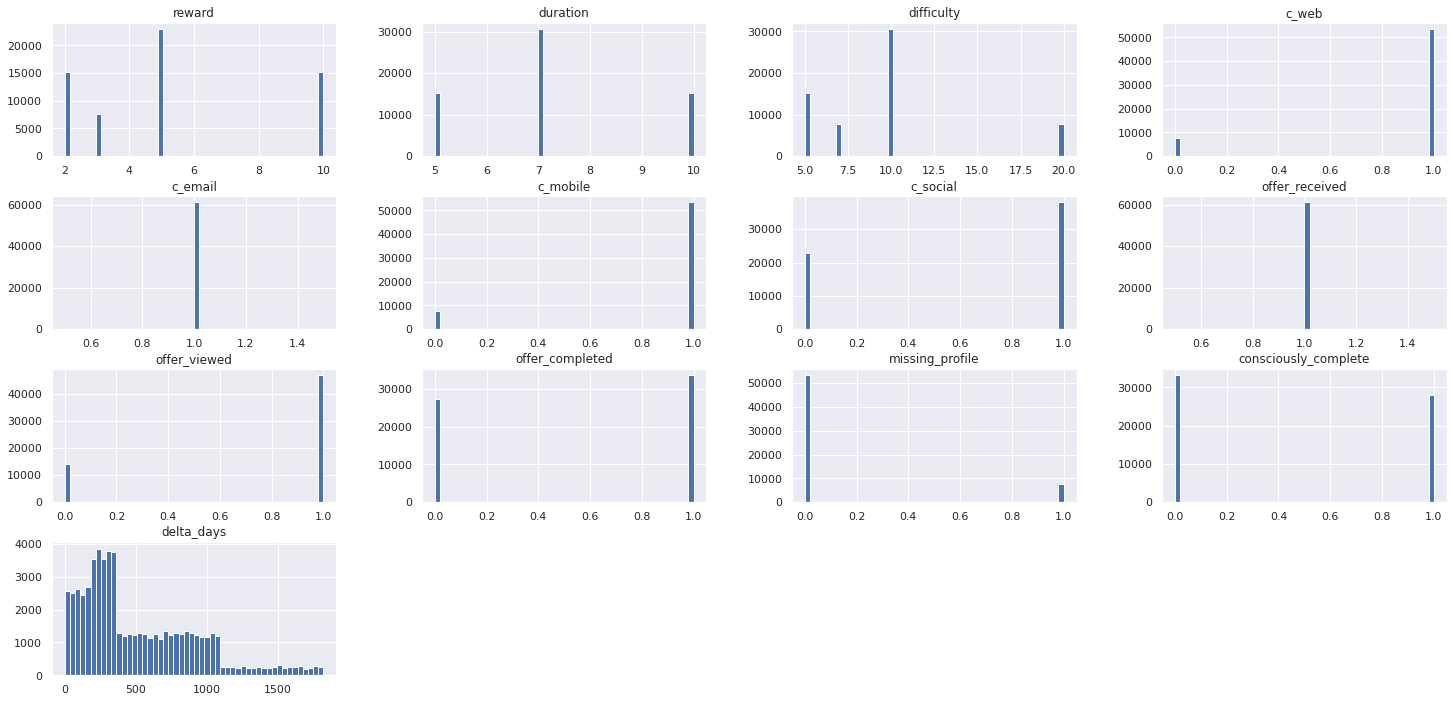

In [40]:
df4.drop(['age', 'income', 'became_member_on'], axis=1).hist(bins=50);

### 4.1.2. Categorical Variable

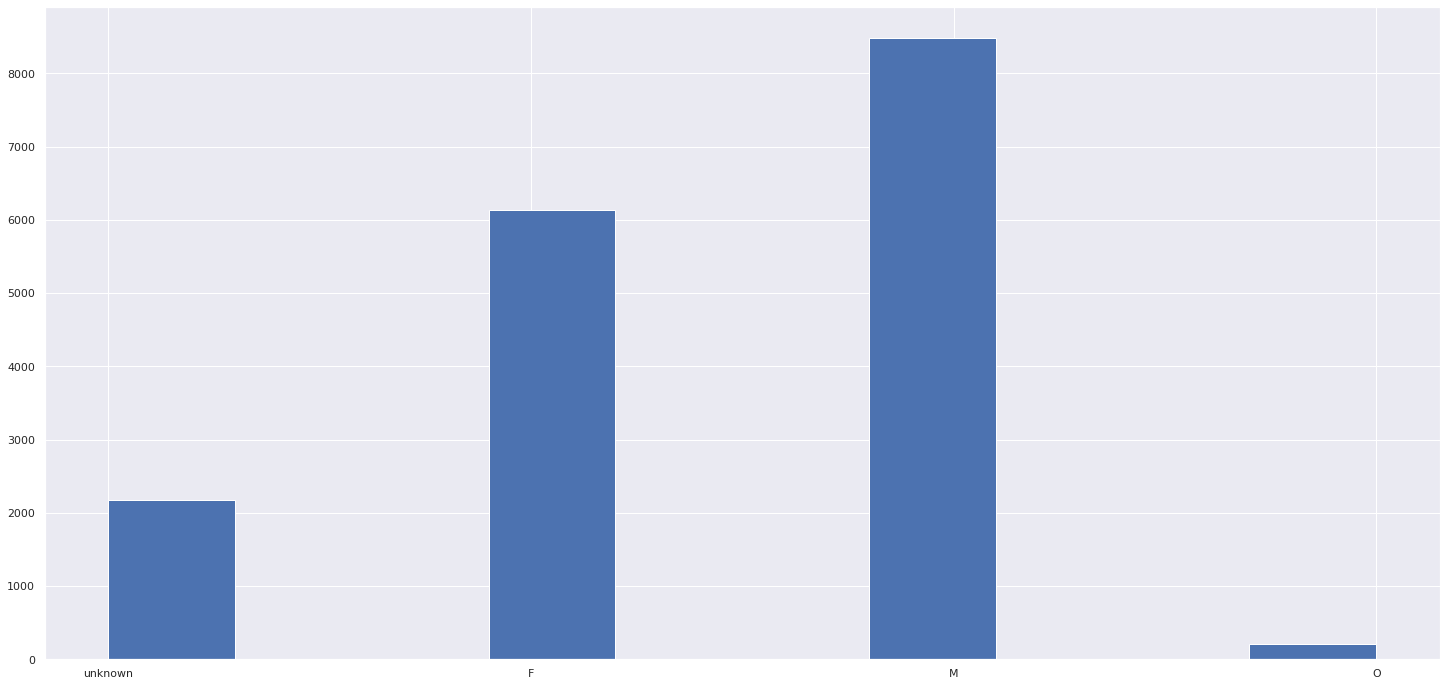

In [42]:
df_profile['gender'].hist();

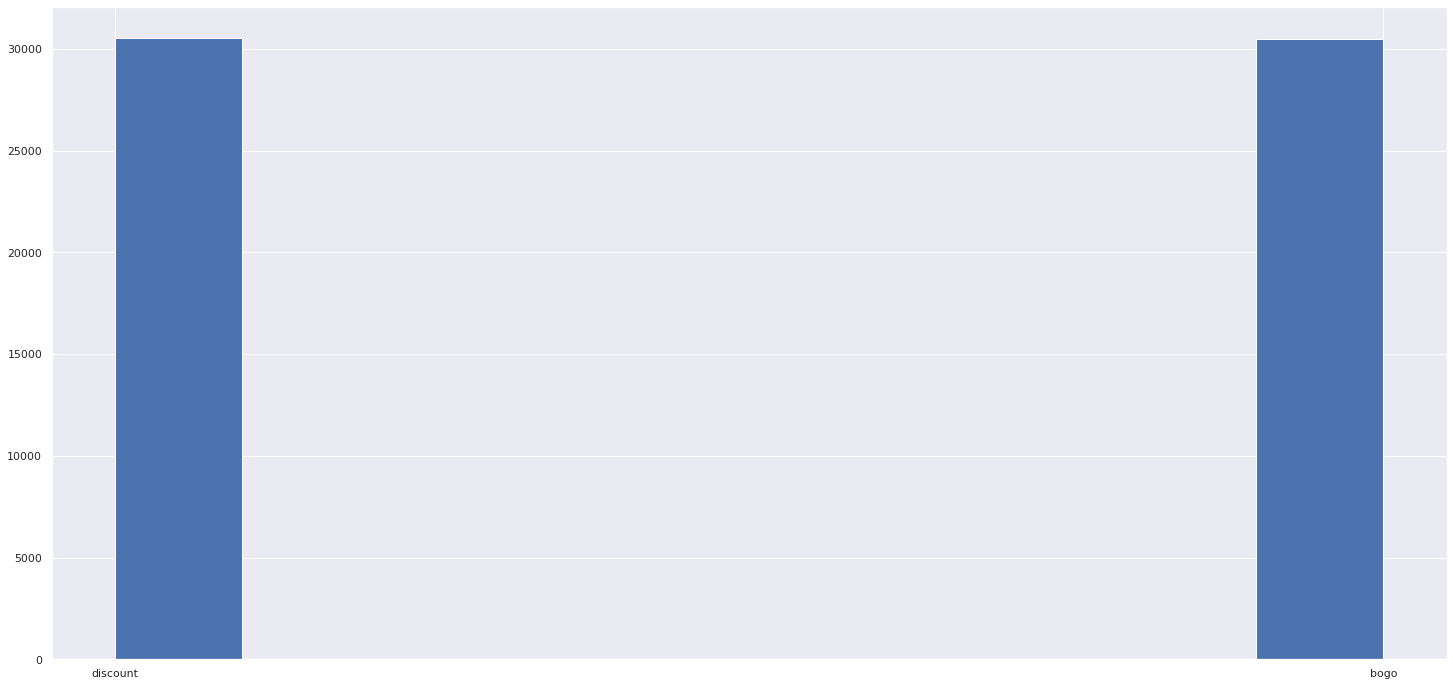

In [43]:
df4['offer_type'].hist();

## 4.2. Bivariate Analysis
### Hypothesis:
**1. Age does not interfere with the completeness of the offers**    
**2. Gender does not interfere with the completeness of the offers**   
**3. People with the highest income complete more offers**  

### 1. Age does not interfere with the completeness of the offers

In [264]:
aux = df4[['age', 'consciously_complete']].groupby('age').agg(['sum', 'count', 'mean']).consciously_complete.reset_index()

In [265]:
aux_2 = aux.copy()

q1 = np.quantile(aux['mean'].values, .25)
q3 = np.quantile(aux['mean'].values, .75)

iqr = q3-q1

upper = q3 + (1.5*iqr)
lower = q1 - (1.5*iqr)

for index, row in aux_2.iterrows():
    if row['mean'] > upper or row['mean'] < lower:
        aux_2.drop(index, inplace=True)

<AxesSubplot:xlabel='age', ylabel='mean'>

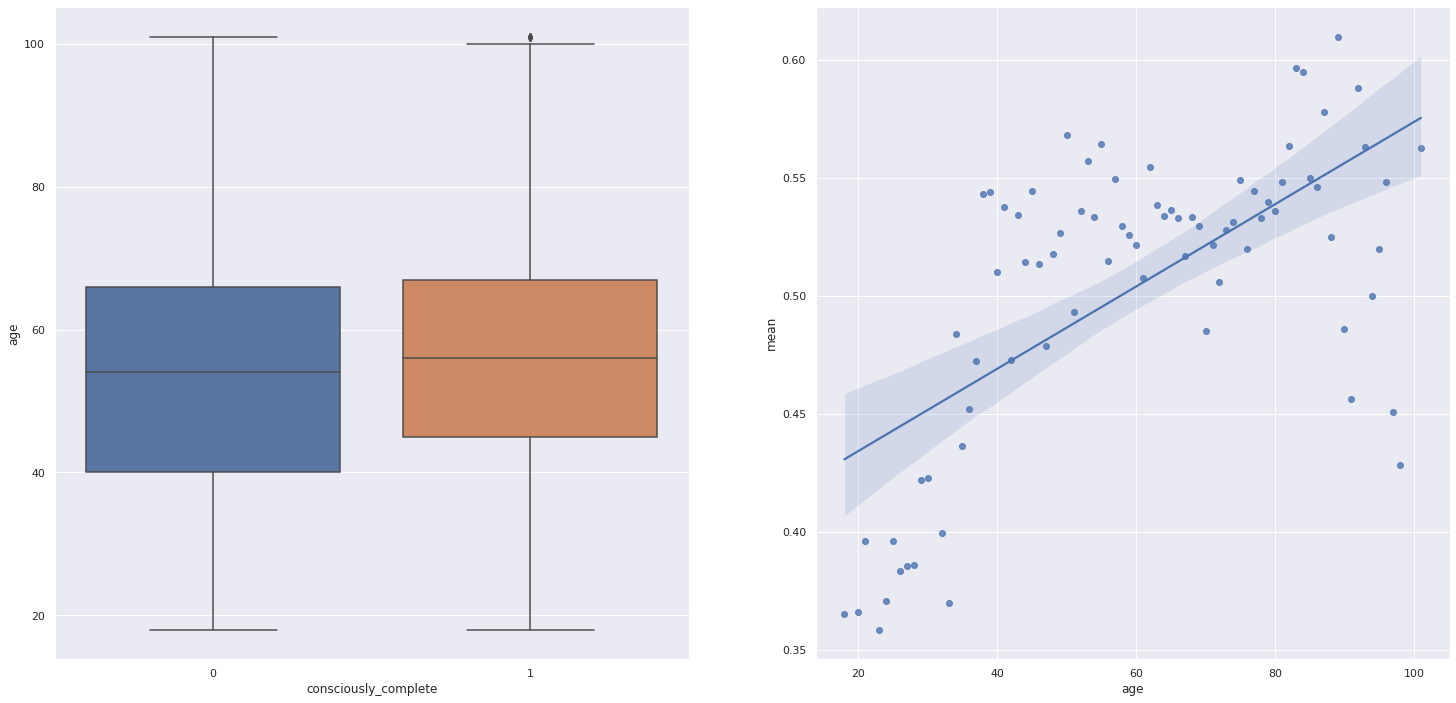

In [266]:
grid = plt.GridSpec(1, 2)

plt.subplot(grid[0, 0])
a = sns.boxplot(x=df4['consciously_complete'], y=df4['age'])

plt.subplot(grid[0, 1])
sns.regplot(x=aux_2['age'], y=aux_2['mean'])

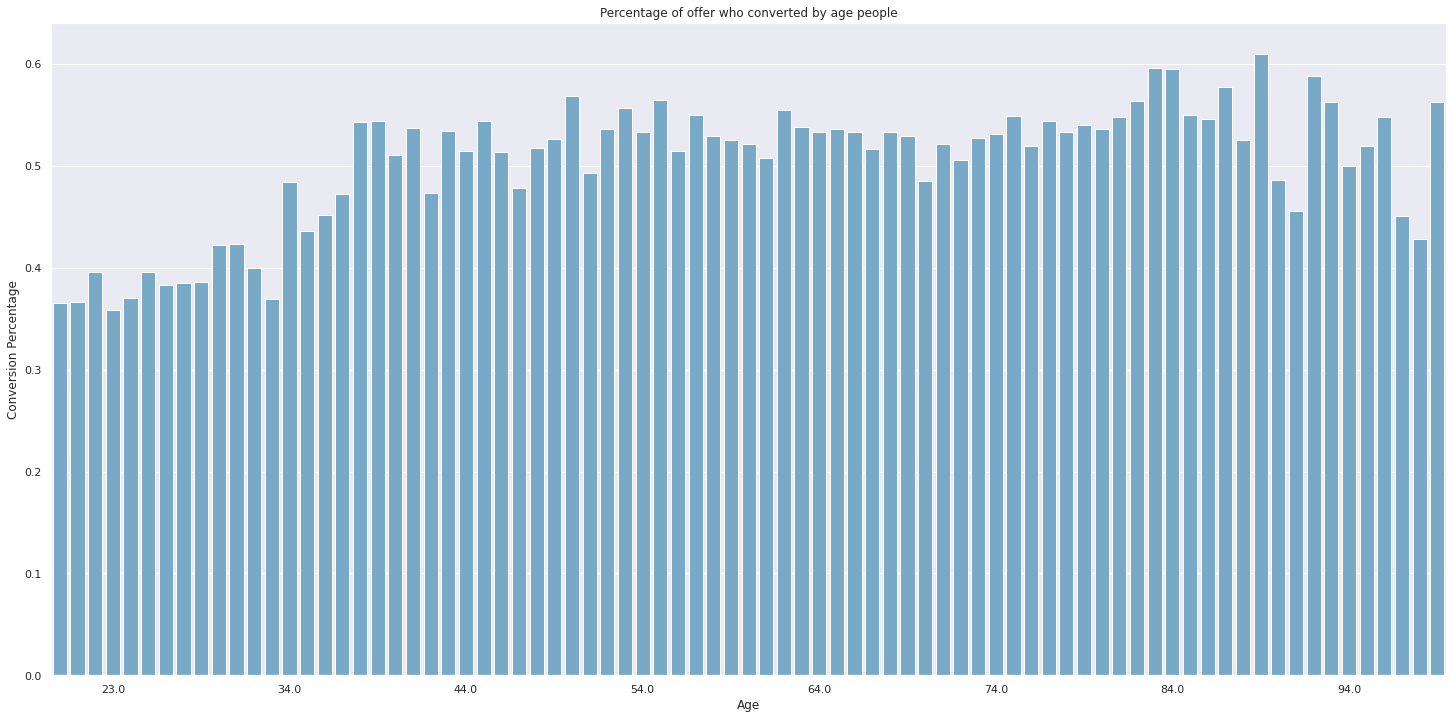

In [320]:
sns.barplot(x=aux_2['age'], y=aux_2['mean'], palette=sns.color_palette('Blues', 1))

plt.xticks(np.arange(min(aux_2['age']) -15, max(aux_2['age']) - 20, 10))
plt.title('Percentage of offer who converted by age people')
plt.ylabel('Conversion Percentage')
plt.xlabel('Age')

plt.savefig('img/age')

### 2. Gender does not interfere with the completeness of the offers

In [291]:
aux = df4[['gender', 'consciously_complete']].groupby('gender').agg(['sum', 'count', 'mean']).consciously_complete.reset_index().sort_values(by='mean', ascending=False)

In [292]:
aux

,gender,sum,count,mean
2,O,453,721,0.628294
0,F,12654,21918,0.577334
1,M,13814,30562,0.451999
3,unknown,1029,7841,0.131233


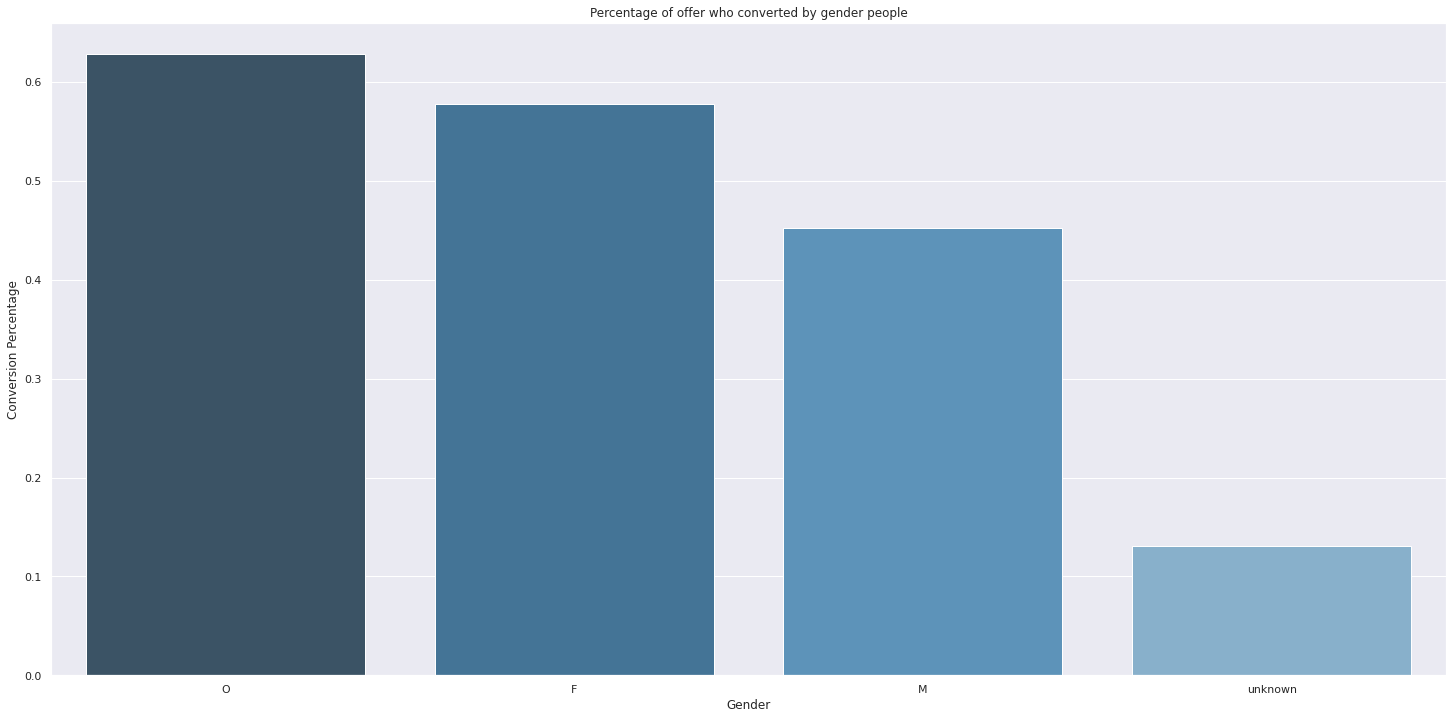

In [294]:
palettes = sns.color_palette('Blues_d', n_colors=4)[::-1]
sns.barplot(x=aux['gender'], y=aux['mean'], palette=palettes)

plt.title('Percentage of offer who converted by gender people')
plt.ylabel('Conversion Percentage')
plt.xlabel('Gender')

plt.savefig('img/gender')

### 3. People with the highest income complete more offers

In [295]:
aux = df4[['income', 'consciously_complete']].groupby('income').agg(['sum', 'count', 'mean']).consciously_complete.reset_index().sort_values(by='mean', ascending=False)

In [296]:
aux_2 = aux.copy()

q1 = np.quantile(aux['mean'].values, .25)
q3 = np.quantile(aux['mean'].values, .75)

iqr = q3-q1

upper = q3 + (1.5*iqr)
lower = q1 - (1.5*iqr)

for index, row in aux_2.iterrows():
    if row['mean'] > upper or row['mean'] < lower:
        aux_2.drop(index, inplace=True)

<AxesSubplot:xlabel='income', ylabel='mean'>

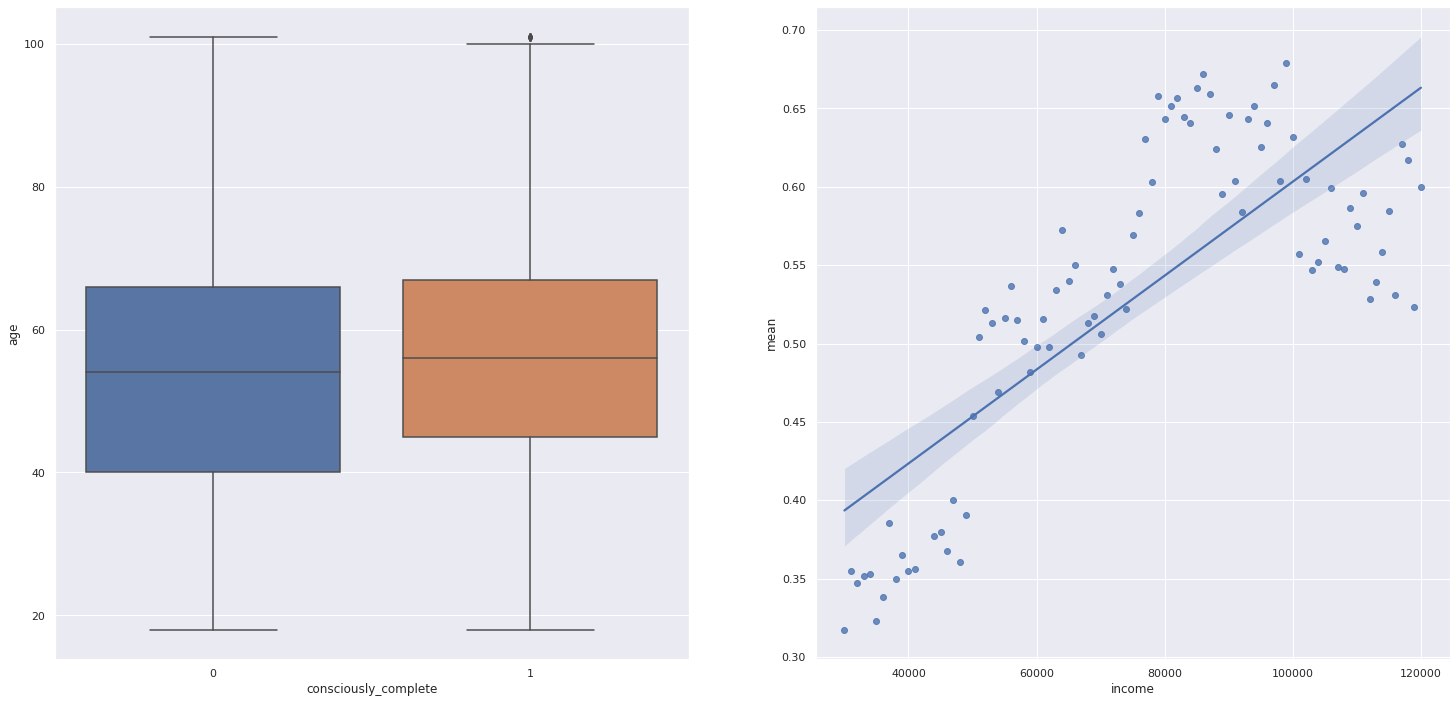

In [297]:
grid = plt.GridSpec(1, 2)

plt.subplot(grid[0, 0])
a = sns.boxplot(x=df4['consciously_complete'], y=df4['age'])

plt.subplot(grid[0, 1])
sns.regplot(x=aux_2['income'], y=aux_2['mean'])

In [301]:
aux_2

,income,sum,count,mean
69,99000.0,298,439,0.678815
56,86000.0,305,454,0.671806
67,97000.0,296,445,0.665169
55,85000.0,358,540,0.662963
57,87000.0,369,560,0.658929
...,...,...,...,...
8,38000.0,230,658,0.349544
2,32000.0,281,809,0.347342
6,36000.0,238,703,0.338549
5,35000.0,247,765,0.322876


In [312]:
from matplotlib.ticker import MaxNLocator

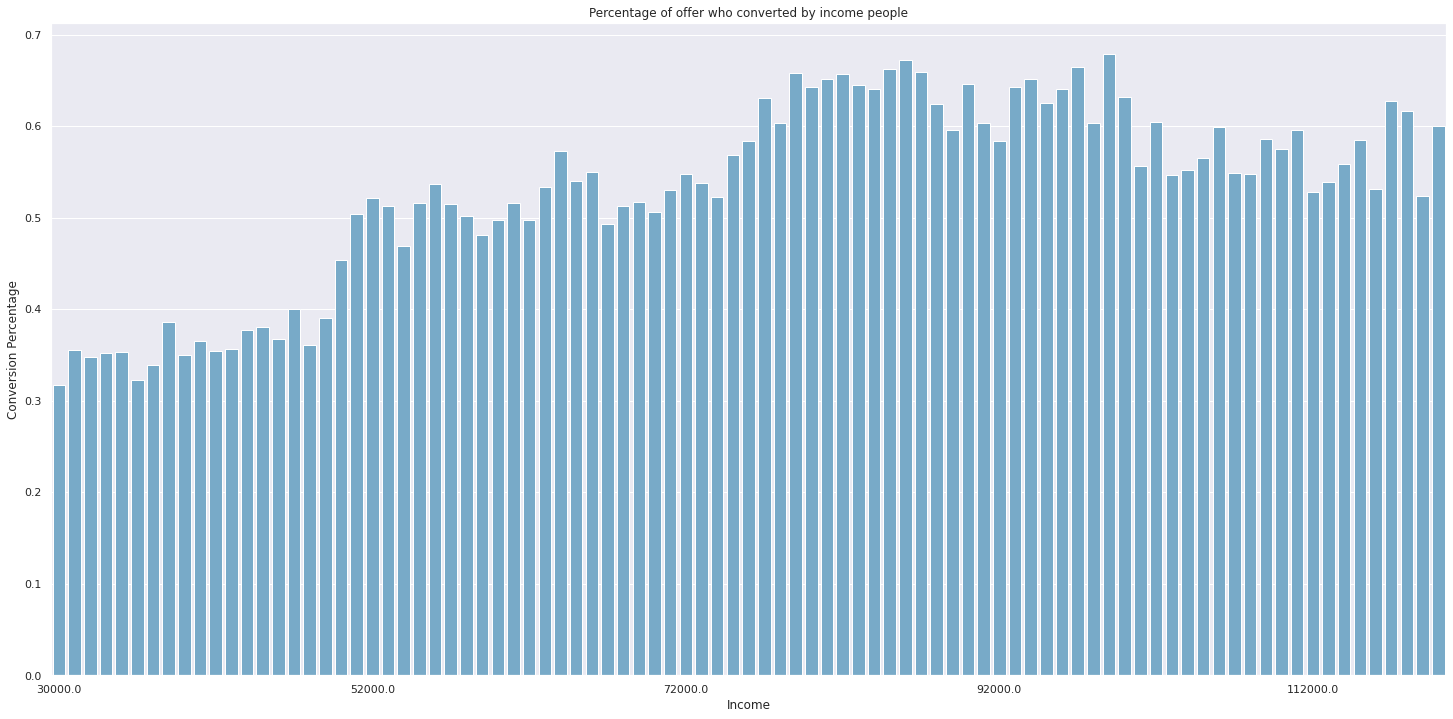

In [314]:
fig, axes = plt.subplots()
sns.barplot(x=aux_2['income'], y=aux_2['mean'], palette=sns.color_palette('Blues', 1))

axes.xaxis.set_major_locator(MaxNLocator(5)) 
plt.title('Percentage of offer who converted by income people')
plt.ylabel('Conversion Percentage')
plt.xlabel('Income')

plt.savefig('img/income')

# 5.0. Data Pre-Processing

In [54]:
df5 = df4.copy()

In [55]:
df5.head()

,person,age,gender,income,became_member_on,code,offer_type,reward,duration,difficulty,c_web,c_email,c_mobile,c_social,offer_received,offer_viewed,offer_completed,missing_profile,consciously_complete,delta_days
0,0009655768c64bdeb2e877511632db8f,33.0,M,72000.0,2017-04-21,2906b810c7d4411798c6938adc9daaa5,discount,2,7,10,1,1,1,0,1,0,1,0,0,461
1,00426fe3ffde4c6b9cb9ad6d077a13ea,19.0,F,65000.0,2016-08-09,2906b810c7d4411798c6938adc9daaa5,discount,2,7,10,1,1,1,0,1,0,0,0,0,716
2,00426fe3ffde4c6b9cb9ad6d077a13ea,19.0,F,65000.0,2016-08-09,2906b810c7d4411798c6938adc9daaa5,discount,2,7,10,1,1,1,0,1,0,0,0,0,716
3,005500a7188546ff8a767329a2f7c76a,56.0,M,47000.0,2017-12-09,2906b810c7d4411798c6938adc9daaa5,discount,2,7,10,1,1,1,0,1,0,0,0,0,229
4,0069a50874d846438e58acff5e594725,NaN,unknown,NaN,2016-05-03,2906b810c7d4411798c6938adc9daaa5,discount,2,7,10,1,1,1,0,1,1,1,1,1,814


## 5.1. Filtering Columns

Selecting only the columns that will actually be used in the model.   
* person and code should be excluded as it has no predictive power.  
* offer_received and c_email can be excluded because all values are 1.   
* offer_viewed will be excluded because it would generate data leakage, because at the time of prediction we don't know if the user saw it or not.

In [237]:
df5 = df4.copy()

In [238]:
df5 = df5[['age', 'gender', 'income', 'delta_days', 'offer_type', 'reward', 'duration', 
           'difficulty', 'c_web', 'c_mobile', 'c_social', 'missing_profile', 'consciously_complete']]

## 5.2. Encoding
The model will not work with categorical data. For this, it is necessary to make a transformation so that they become numerical data.   
For this, One Hot Enconde works well for cases with little data, as it transforms each type of input from a categorical column into a new column.   
This process will be done on the gender and offer_type columns.

In [57]:
# gender / offer_type -> One Hot Encoding
df5 = pd.get_dummies(df5, 'g_', columns=['gender'])
df5 = pd.get_dummies(df5, 'ot_', columns=['offer_type'], drop_first=True)

In [239]:
df5.head()

,age,gender,income,delta_days,offer_type,reward,duration,difficulty,c_web,c_mobile,c_social,missing_profile,consciously_complete
0,33.0,M,72000.0,461,discount,2,7,10,1,1,0,0,0
1,19.0,F,65000.0,716,discount,2,7,10,1,1,0,0,0
2,19.0,F,65000.0,716,discount,2,7,10,1,1,0,0,0
3,56.0,M,47000.0,229,discount,2,7,10,1,1,0,0,0
4,NaN,unknown,NaN,814,discount,2,7,10,1,1,0,1,1


# 5.3. Split Dataset
To evaluate our model, we must separate training and test data. The training data will only be used at the end for the model evaluation.   
This separation will follow the 80/20 rule. 80% of the data will be used for training and 20% for testing. This is my choice as the test data could be a higher percentage. However, due to the smaller amount of data I chose 20% for testing.

In [59]:
# Separating response variable
X = df5.drop('consciously_complete', axis=1)
y = df5.loc[:, 'consciously_complete']

In [60]:
X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2, random_state=32, stratify=y)

## 5.4. Feature Selection
Not all features are important for our model. Some can even make it worse. There are some techniques to find out which features are most important for the case. Two will be used in this project:
1. Manual Feature Selecion
2. RFE

## 5.4.1. Feature Importance

In [61]:
def train_pipeline(X_train, y_train, model):
    imp = SimpleImputer(missing_values=np.nan, strategy='mean')
    
    pipeline = Pipeline([
        ('imp', imp),
        ('clf', model)
    ])
    
    pipeline.fit(X_train, y_train)
    
    return pipeline

In [62]:
rf_model = en.RandomForestClassifier(n_jobs=-1)
model = train_pipeline(X_train, y_train, rf_model)

<AxesSubplot:>

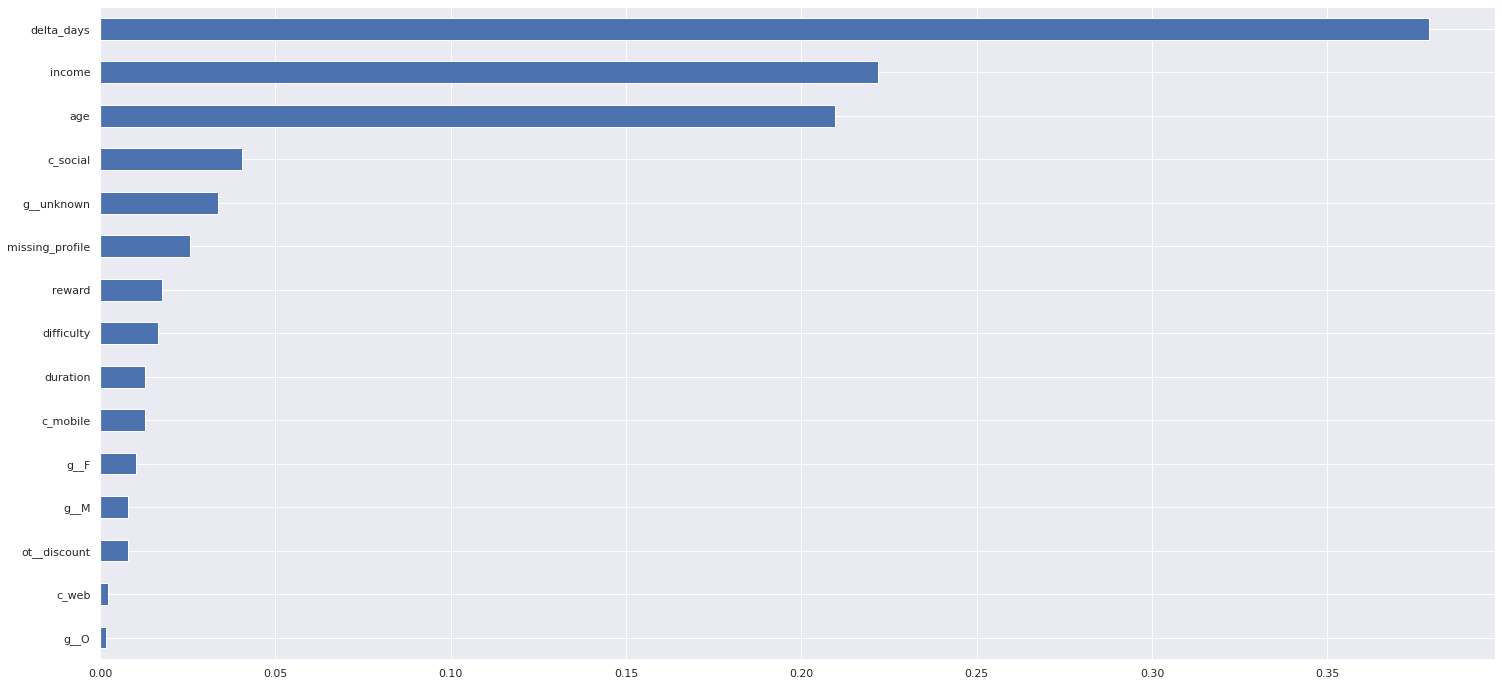

In [63]:
# feature importances
feat_importances = pd.Series(model.steps[1][1].feature_importances_, index=X_train.columns)

# plot feature importances
feat_importances.sort_values().plot(kind='barh')

In [64]:
rfe_model = fs.RFE(estimator=model.steps[1][1], n_features_to_select=5)
model = train_pipeline(X_train, y_train, rfe_model)

In [65]:
# show values
for i in range(X_train.shape[1]):
    print('{} - Rank: {}'.format(X_train.columns[i], model.steps[1][1].ranking_[i]))

age - Rank: 1
income - Rank: 1
delta_days - Rank: 1
reward - Rank: 1
duration - Rank: 5
difficulty - Rank: 4
c_web - Rank: 10
c_mobile - Rank: 7
c_social - Rank: 1
missing_profile - Rank: 2
g__F - Rank: 8
g__M - Rank: 6
g__O - Rank: 11
g__unknown - Rank: 3
ot__discount - Rank: 9


## 5.4.2. Selecting Features 
I will select only the 8 columns that performed best in both tests.

In [66]:
features = ['age', 'income', 'delta_days', 'reward', 'difficulty',
            'duration', 'c_social', 'g__unknown', 'g__F']

X_train = X_train[features]
X_test = X_test[features]

# 6.0. Model
To create the model, I will use four classification models and choose the one with the best overall performance.   
To impute the missing data, I will use the averaging strategy.   
Cross validation will be used to divide the training data into Training and Validation. There will be 5 divisions and the final result of the metric will be the average of these 5.   
The metrics used will be:
* Accuracy
* Precision
* Recall
* F1
* ROC/AUC

**LGBM, Catboost and XGB performed very similarly. To continue, I will initially use XGBoost because I believe that the performance can have a higher increase than the others in the tuning of hyperparameters.**

In [241]:
def evaluate_models(X, y, list_models, cv_iter=5, imput_strat='mean'):
    """
    Evaluates the models listed in Cross validation and returns a dataframe 
    with the average performance of each metric for each model.
    """
    imp = SimpleImputer(missing_values=np.nan, strategy=imput_strat)
    
    for count, model in enumerate(list_models):
        pipeline = Pipeline([
            ('imp', imp),
            ('clf', model)
        ])

        scoring = {'acc': 'accuracy',
                   'precision': 'precision',
                   'recall': 'recall',
                   'f1': 'f1',
                   'roc_auc': 'roc_auc'}

        scores = ms.cross_validate(pipeline, X, y, cv=cv_iter, scoring=scoring)

        if count == 0:
            df_scores = pd.DataFrame(pd.DataFrame(scores).mean()).T
            df_scores.index = index=[type(model).__name__]

        else:
            df_aux = pd.DataFrame(pd.DataFrame(scores).mean()).T
            df_aux.index = index=[type(model).__name__]
            df_scores = pd.concat([df_scores, df_aux])
            
    return df_scores

In [68]:
# list of models to show performance in train dataset
list_models = [
    lm.LogisticRegression(random_state=32),
    LGBMClassifier(n_jobs=-1, random_state=32),
    cb.CatBoostClassifier(verbose=0, random_state=32),
    xgboost.XGBClassifier(n_jobs=-1, random_state=32), 
]

In [69]:
evaluate_models(X_train, y_train, list_models)

,fit_time,score_time,test_acc,test_precision,test_recall,test_f1,test_roc_auc
LogisticRegression,0.187680,0.022442,0.621035,0.593230,0.548301,0.569838,0.667856
LGBMClassifier,0.156411,0.026567,0.736531,0.730651,0.672540,0.700380,0.816259
CatBoostClassifier,3.616485,0.021844,0.736674,0.727690,0.679114,0.702535,0.817584
XGBClassifier,0.603630,0.023725,0.737780,0.726183,0.686091,0.705534,0.816241


# 7.0. Hyperparameter Fine Tuning
Here in funetunning some hyperparameters will be selected with some values. These values will be combined and we will have a final model with the best hyperparameters for the model.   
For this, the GridSearchCV was used, which returns all possible combinations of the inserted hyperparameters.   
The Metric used for this will be the metric used during the evaluation: The Precision.
Precision tells us of those inputs that our model predicted as a conversion, how many actually are. 
I believe it is the best metric because it allows us to say how assertive we are with those coupons that we are delivering.

In [176]:
def final_model(model, imput_strat='mean'):
    """
    Function that performs the finetuning of the model with the desired parameters
    """
    imp = SimpleImputer(missing_values=np.nan, strategy=imput_strat)
    
    pipeline = Pipeline([
        ('imp', imp),
        ('clf', model)
        ])

    train_model = ms.GridSearchCV(pipeline, parameters, verbose=0, scoring='precision', n_jobs=-1)
    
    return train_model

In [177]:
parameters = {
'clf__max_depth': (3, 6, 10),
'clf__n_estimators': (100, 500, 1000),
'clf__learning_rate': (0.1, 0.2, 0.3),
'clf__colsample_bytree': (0.3, 0.5, 0.10),
'clf__subsample': (0.3, 0.5, 0.10),
}

In [178]:
model = xgboost.XGBClassifier(n_jobs=-1, random_state=32)

In [179]:
final_model = final_model(model)

In [180]:
final_model.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('imp', SimpleImputer()),
                                       ('clf',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      gamma=None, gpu_id=None,
                                                      grow_policy=None,
                                                      importan

In [181]:
final_model.best_params_

{'clf__colsample_bytree': 0.5,
 'clf__learning_rate': 0.1,
 'clf__max_depth': 10,
 'clf__n_estimators': 100,
 'clf__subsample': 0.5}

In [244]:
final_model.best_score_

0.7247593607591303

# 8.0. Evaluating
The last step is to assess how well our model is dealing with never-before-seen data. For that, we need to have a baseline that allows us to compare the model to something.   

## 8.1. Baseline
The Baseline for the case will be all coupons being delivered to all cases in the dataset. So y_predict = 1 for all cases. This makes sense as this is exactly what was done in the case.

In [182]:
df_test = pd.merge(X_test, y_test, left_index=True, right_index=True)

In [183]:
df_test['pred'] = 1

In [207]:
base_prec = me.precision_score(df_test['consciously_complete'], df_test['pred']) * 100
base_recall = me.recall_score(df_test['consciously_complete'], df_test['pred']) * 100
base_accuracy = me.accuracy_score(df_test['consciously_complete'], df_test['pred']) * 100

## 8.2. Model
Here the metrics for the model we created with the test data will be generated.

In [208]:
predicts_test = final_model.predict(X_test)

In [209]:
model_prec = me.precision_score(y_test, predicts_test) * 100
model_recall = me.recall_score(y_test, predicts_test) * 100
model_accuracy = me.accuracy_score(y_test, predicts_test) * 100

## 8.3. Compare
With the comparison it is possible to visualize 2 main insights:
* Regarding precision (Of those data that were predicted as positive, how many are actually positive), our model significantly increased performance:
    - Baseline: 45.79% Precision
    - Model: 72.56% Precision
    
* Regarding the recall (Of those that are really positive, how many our model predicted as positive), the baseline had a 100% performance, well above the model. But this, when viewed in aggregate, is not necessarily a good thing because the baseline is considering all cases to be positive. That way, she has a wider range of hits, but misses in many cases, as can be seen by her precision and recall.

In [252]:
df_compare = pd.DataFrame({'Baseline': [base_prec, base_recall, base_accuracy],
                           'Model': [model_prec, model_recall, model_accuracy]},
                          index=['Precision', 'Recall', 'Accuracy']).T.reset_index()
df_compare.rename({'index': 'Type'}, axis=1, inplace=True)

In [253]:
df_compare

,Type,Precision,Recall,Accuracy
0,Baseline,45.785896,100.000000,45.785896
1,Model,72.561205,68.926655,73.838971


In [254]:
df_compare_aux = df_compare.melt(id_vars='Type').rename(columns=str.title)

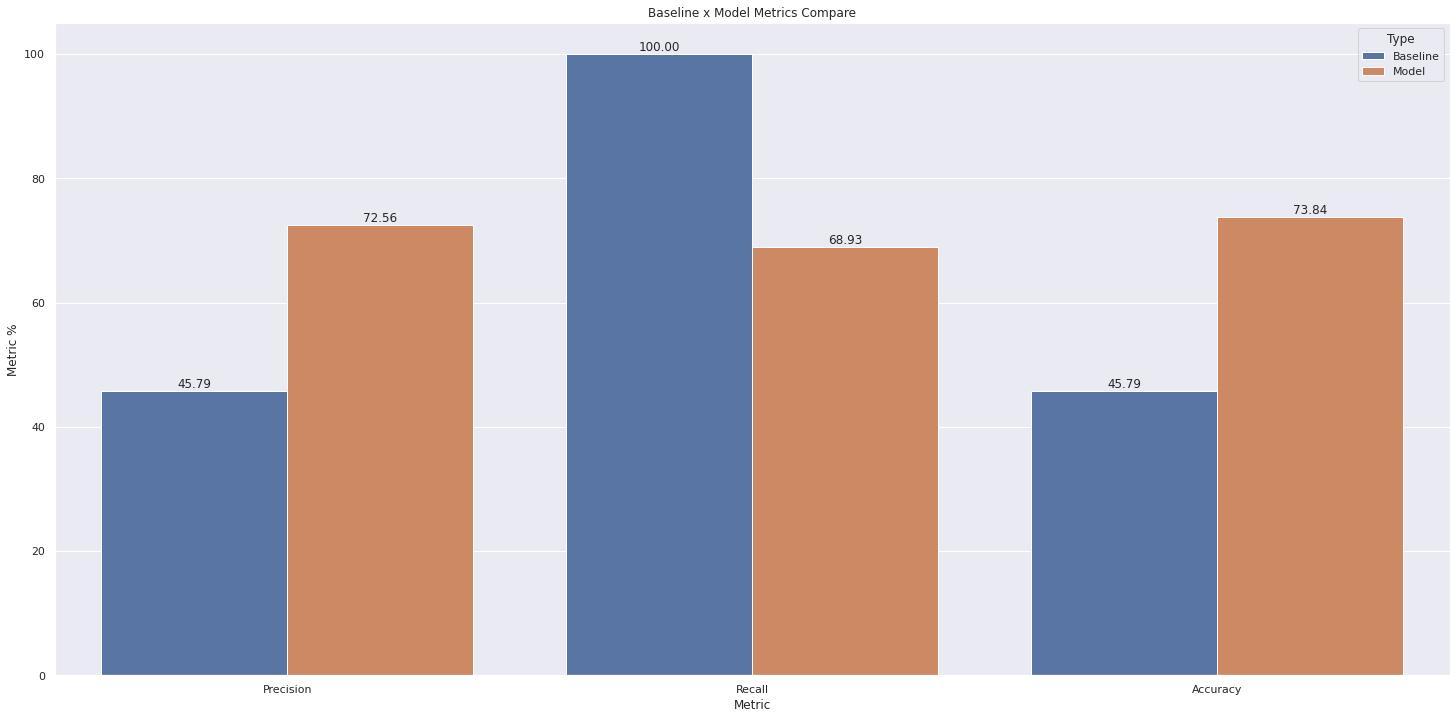

In [255]:
fig, ax = plt.subplots()

sns.barplot(x='Variable', y='Value', hue='Type', data=df_compare_aux)

plt.title('Baseline x Model Metrics Compare')
plt.ylabel('Metric %')
plt.xlabel('Metric')

ax.bar_label(ax.containers[-2], fmt='%.2f', label_type='edge')
ax.bar_label(ax.containers[-1], fmt='%.2f', label_type='edge');

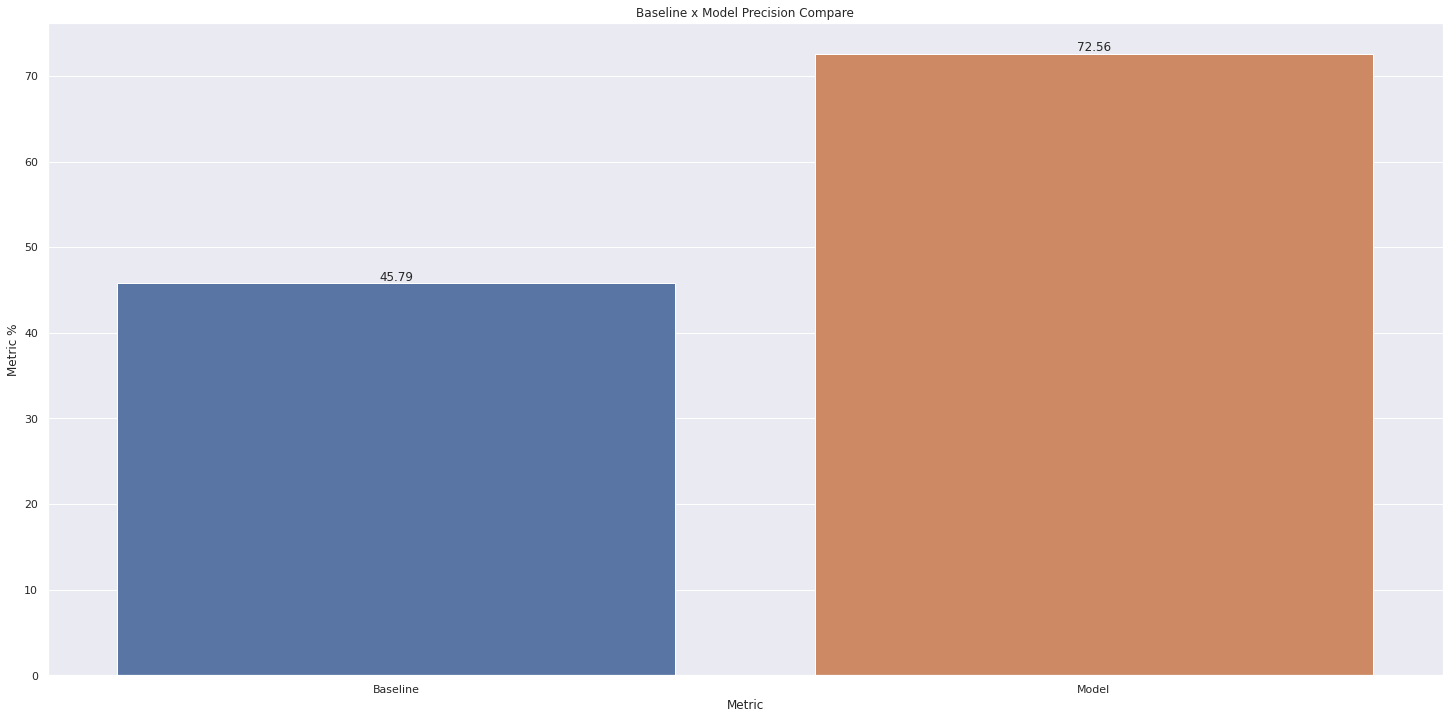

In [260]:
fig, ax = plt.subplots()

sns.barplot(x='Type', y='Precision', data=df_compare)

plt.title('Baseline x Model Precision Compare')
plt.ylabel('Metric %')
plt.xlabel('Metric')

ax.bar_label(ax.containers[-1], fmt='%.2f', label_type='edge');

plt.savefig('img/precision')